# RNN을 이용한 텍스트 생성기(Text Generator using RNN)
## 샘플 코드를 기반으로 한 텍스트 생성 프로그램입니다.(Text Generator based on sample code)
### 한국어 설명
그럴듯한 텍스트 생성을 위해서는 최소 5000 Epoch의 학습이 필요합니다.
<br> 이 코드는 Keras 예제, Tensorflow 예제와 같은 코드를 참고하여 제작되었습니다.
<br>
<br> 몇가지 유의사항:
<br>- 이 프로그램은 대용량 텍스트 처리에 적합하지 <b>않습니다</b>.
<br>- 이 프로그램은 모든 언어에 대응합니다. (일단, 한국어 구동은 확인했습니다.)
<br>- RNN의 계산량이 매우 많음에 따라 GPU환경에서 구동하는 것을 추천드립니다.
<br>
### EN Version.
At least 5000 epochs are required before the generated text starts sounding coherent.
<br> *(This model is inspired by many examples, such as Keras samples, or tensorflow tutorials.)*
<br>
<br> Few notices:
<br>- This script is <b>NOT</b> designed for large text.
<br>- This script is designed for ANY language. (It works for my language, at least.)
<br>- It is recommended to run this script on GPU, as recurrent networks are quite computationally intensive.

In [1]:
import os
import time
import chardet
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\jungw\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Class 상세
- \_\_init\_\_: 인코딩(Encoding) 옵션과 함께 파일을 로드합니다.
    - 기본 인코딩: None
- Slice_Data: 텍스트를 글자 단위로 분할합니다. (올바른 방법으로 수정할 경우, 단어 단위로도 가능)
- Data2idx: 텍스트 데이터를 인덱스(Index)로 변환합니다.
- Build_Data: 변환된 텍스트 데이터를 기반으로 시퀀스를 생성합니다.
    - 기본 Stride: 1
- LSTM_Cell: rnn.MultiRNNCell에서 쓰이는 LSTM 셀 구조
- Make_Text: 텍스트 데이터를 기반으로 텍스트를 생성합니다.
- Elapsed: 작업 경과시간 측정 용도
- Save_Model: 현재 모델을 저장합니다.
    - Default Global_step: 1000
- Load_Model: 특정 모델 파일을 불러옵니다.
- Plot_Iter_Loss: Matplotlib을 사용하여 Iteration대비 Loss를 그래프로 그려줍니다.
- Plot_Time_Loss: 시간대비 Loss를 그래프로 그려줍니다.
- Plot_Time_Iter: Iteration대비 시간 경과를 그래프로 그려줍니다.
- Prepare_Model: 학습을 위한 모델 구조를 생성합니다. (X, Y, weight 등)
- Train: 지정된 Epoch숫자만큼 학습을 진행합니다.

### Class Details
- \_\_init\_\_: Load file with encoding option.
    - Default Encoding: None
- Slice_Data: Split text data into characters (This can be words if modified correctly)
- Data2idx: Transform text data into index
- Build_Data: Generate sequences of transformed text data
    - Default Stride: 1
- LSTM_Cell: A LSTM cell, only to use at rnn.MultiRNNCell
- Make_Text: A random text generator, based on text data
- Elapsed: To calculate time elapsed
- Save_Model: Save current Neural Network model
    - Default Global_step: 1000
- Load_Model: Load specified model file
- Plot_Iter_Loss: Plot loss compared to total iteration, using matplotlib.
- Plot_Time_Loss: Plot loss compared to time.
- Plot_Time_Iter: Plot Time compared to total iteration.
- Prepare_Model: Generate model structure for training (X, Y, weight, etc.)
- Train: Start training model with epoch number followed

In [2]:
class TextGen:

    def __init__(self, filename, learning_rate, num_layers, seq_len,
         epoch, save_point, save_at, encode=False, stride=1):
        self.filename = filename
        self.learning_rate = learning_rate
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.epoch = epoch
        self.save_point = save_point
        self.save_at = save_at
        self.encode = encode
        self.stride = stride

    def read_dataset(self):
        try:
            read_file = open(self.filename, 'rb').read()
            if self.encode is True:
                encode_type = chardet.detect(read_file)['encoding']
                print(encode_type)
            else:
                encode_type = None
            # text = open(full_filename, encoding=None).read().lower()
            text = open(self.filename, encoding=encode_type).read()
        except:
            text = False
        print("Load Complete.")
        return text

    def Slice_Data(self):
        char_set = sorted(list(set(self.text)))    # character split
        num_classes = len(char_set)
        char_indices = dict((c, i) for i, c in enumerate(char_set))
        indices_char = dict((i, c) for i, c in enumerate(char_set))
        print("Slice Complete.")
        return char_set, num_classes, char_indices, indices_char

    def Data2idx(self):
        idx_text = []
        for char in self.text:
            idx_text.append(self.char_indices[char])
        text = idx_text
        print("Indexing Complete.")
        return text

    def Build_Data(self):
        x_data = []
        y_data = []
        for i in range(0, len(self.text) - self.seq_len, self.stride):
            fill_x = self.seq_len - len(self.text[i : i+self.seq_len])
            fill_y = self.seq_len - len(self.text[i+1 : i+self.seq_len - 1])
            
            x_text = self.text[i : i+self.seq_len]
            y_text = self.text[i+1 : i+self.seq_len - 1]
            
            if fill_x is not 0:
                x_text.extend([0 for i in range(fill_x)])
            elif fill_y is not 0:
                y_text.extend([0 for i in range(fill_y)])

            x_data.append(x_text)
            y_data.append(y_text)
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        print("Sequencing Complete.")
        return x_data, y_data

    def Make_Text(self, sess):
        self.results = sess.run(self.outputs, feed_dict={self.X: self.x_data})
        for j, result in enumerate(self.results):
            index = np.argmax(result, axis=1)
            if j is 0:  # print all for the first result to make a sentence
                print(''.join([self.indices_char[t] for t in index]), end='')
            else:
                print(self.indices_char[index[-1]], end='')

    def LSTM(self):
        lstm = tf.contrib.rnn.BasicLSTMCell(self.hidden_size,
                                            state_is_tuple = True)
        return lstm

    def BRNN_Dynamic(self, X):
        # Default activation: Tanh
        # Default: state_is_Tuple=True
        # lstm = tf.contrib.rnn.BasicLSTMCell(self.hidden_size, state_is_tuple = True)
        lstm = tf.nn.rnn_cell.DropoutWrapper(self.LSTM(), output_keep_prob=0.8)    # Dropout 0.8
        multi_lstm = tf.contrib.rnn.MultiRNNCell([lstm]*self.num_layers,
                                                state_is_tuple = True)
        # Bidirectional Dynamic RNN
        (fw_output, bw_output), _states = tf.nn.bidirectional_dynamic_rnn(cell_fw=lstm,
                                                                        cell_bw=lstm,
                                                                        inputs=X,
                                                                        dtype=tf.float32)
        outputs = tf.concat([fw_output, bw_output], axis=2)
        return outputs

    def MultiRNN_Dynamic(self, X):
        lstm = self.LSTM()
        # lstm = tf.nn.rnn_cell.DropoutWrapper(self.LSTM(), output_keep_prob=0.9)
        multi_lstm = tf.contrib.rnn.MultiRNNCell([lstm] * self.num_layers,
                                                 state_is_tuple = True)
        outputs, _states = tf.nn.dynamic_rnn(multi_lstm,
                                             X,
                                             dtype=tf.float32)
        return outputs
  
    def Elapsed(self):
        total = self.end - self.start
        m, s = divmod(total, 60)
        h, m = divmod(m, 60)
        
        if m == 0 and h == 0:
            print("Time Elapsed: {:>3d} sec".format(int(s)))
        elif m != 0 and h == 0:
            print("Time Elapsed: {:>3d} min {:>3d} sec".format(int(m), int(s)))
        else:
            print("Time Elapsed: {:>3d} hour {:>3d} min {:>3d} sec".format(int(h), int(m), int(s)))
            
    def Save_Model(self, saver, sess, iter, output=True):
        pathfile, ext = os.path.splitext(self.save_at)
        file = pathfile + '_' + str(iter) + ext
        save_model = saver.save(sess, file)
        if output is True:
            print("Model saved in path: %s" % save_model)
        
    def Plot_Loss(self):
        fig = plt.figure(figsize=(14, 12))
        graph_1 = fig.add_subplot(2, 1, 1)
        graph_1.grid()
        graph_2 = fig.add_subplot(2, 1, 2)
        graph_2.grid()
        graph_1.plot(self.iter_loss,
                     label='Loss v. Iter')
        graph_2.plot(self.elapsed,
                     self.iter_loss,
                     label='Loss v. Time')
        
        graph_1.set_xlabel('Iter')
        graph_1.set_ylabel('Loss')
        graph_1.set_title('Loss vs Epoch')
        graph_2.set_xlabel('Time(sec)')
        graph_2.set_ylabel('Loss')
        graph_2.set_title('Loss vs Time')
        plt.show()
        
    def Plot_Time_Iter(self):
        plt.figure()
        plt.plot(self.elapsed)
        plt.xlabel('Iter')
        plt.ylabel('Time')
        plt.title('Iter vs Time')
        plt.show()

    def Prepare_Model(self):
        
        # load data
        self.text = self.read_dataset()
        self.char_set, self.num_classes, self.char_indices, self.indices_char = self.Slice_Data()
        self.text = self.Data2idx()
        self.x_data, self.y_data = self.Build_Data()

        print("Text length: %s" % len(self.text))
        print("Number of characters: {}".format(self.num_classes))    # length check
        print("Dataset X has {} sequences.".format(len(self.x_data)))    # dataset shape check
        print("Dataset Y has {} sequences.".format(len(self.y_data)))
        print("Dataset X has {} shape.".format(self.x_data.shape))

        # batch_size: Mini batch size
        # data_dims: 한번에 몇개의 feature가 있는가 (몇글자, 몇단어, 등등)
        # output_dim: 한번에 몇개의 feature가 출력되는가
        # seq_len: 힌번에 몇 sequence(또는 문장)씩 넣는가
        self.batch_size = len(self.x_data)
        self.data_dims = len(self.x_data)
        self.hidden_size = self.num_classes

        self.X = tf.placeholder(tf.int32, [None, self.seq_len])
        self.Y = tf.placeholder(tf.int32, [None, self.seq_len])

        # One-hot encoding
        # X_one_hot = tf.one_hot(self.X, self.num_classes)
        # print(X_one_hot)
        
        # Embedding
        embedding = tf.get_variable(
            "embedding",
            [self.seq_len, self.num_classes],
            dtype=tf.float32)
        print(embedding)
        input_X = tf.nn.embedding_lookup(embedding, self.X)
        
        # LSTM Cell
        outputs = self.MultiRNN_Dynamic(input_X)
        
        # Add Softmax Layer
        X_for_softmax = tf.reshape(outputs,
                                   [-1, self.hidden_size])    # FC layer, x2 for BRNN
        self.outputs = tf.contrib.layers.fully_connected(outputs,
                                                        self.num_classes,
                                                        activation_fn=None)

        # Initialize fc weights with Ones
        # If all weights are not same, loss will explode!!
        weights = tf.ones([self.batch_size, self.seq_len])

        # Monitor loss
        loss = tf.contrib.seq2seq.sequence_loss(logits=self.outputs,
                                                targets=self.Y,
                                                weights=weights)
        self.mean_loss = tf.reduce_mean(loss)
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = optimizer.minimize(self.mean_loss)

    def Train(self, sess):
        saver = tf.train.Saver()
        
        sess.run(tf.global_variables_initializer())
        print('=' * 20, "{:^20}".format("Training Start"), '=' * 20)

        self.iter_loss = []
        self.elapsed = []
        loss_prev = 99999
        
        self.start = time.time()
        for i in range(self.epoch):
            _, l, results = sess.run(
                [self.train_op, self.mean_loss, self.outputs],
                feed_dict={self.X: self.x_data, self.Y: self.y_data})
            self.end = time.time()
            self.elapsed.append(self.end - self.start)    # Time & Iteration
            self.iter_loss.append(l)    # Iteration & Loss
            for j, result in enumerate(results):
                index = np.argmax(result, axis=1)
                if i % 100 == 0 and j == 0:
                    print("\n At step", i, ':',
                        ''.join([self.indices_char[t] for t in index]))
                    print('Loss:', l)
                    self.end = time.time()
                    self.Elapsed()
            if loss_prev > l:
                self.Save_Model(saver, sess, "BEST", output=False)
                loss_prev = l
            elif i % self.save_point is 0:
                self.Save_Model(saver, sess, i)

## 현재 과정 설명
1. 데이터를 로드합니다.
    - 이 경우, 텍스트 데이터의 형태를 띄고 있으면 어떤 데이터든 상관없습니다.
2. Learning Rate를 설정합니다. (여기서는 0.1로 설정했습니다.)
3. 학습을 위한 모델 구조를 설정합니다. 해당 과정은 다음과 같은 과정을 거칩니다.
    - 데이터 분할: 텍스트를 글자 단위로 분할합니다.
    - 데이터 변환: 텍스트 데이터를 인덱스(Index)로 변환합니다.
    - 시퀀스 생성: 변환된 텍스트 데이터를 기반으로 시퀀스를 생성합니다.
    - 기본값 셋팅: data_dim(입력 글자 가지수), hidden_size, num_classes(출력 글자 가지수),
    <br>learning_rate, batch_size(여기서는 시퀀스의 총 길이로 설정)
    - Input 형태 설정: [None, 시퀀스 길이]
    - Truth 형태 설정: [None, 시퀀스 길이]
    - One-hot Encoding 진행
    - LSTM을 2중으로 중첩(2-Layer RNN)
    - dynamic_rnn을 거쳐 output을 생성
    - 마지막으로 FC(Fully Connected, DenseNet)를 거쳐 Output(예측값) 생성
    - 형태 재조정을 위해 reshape
    - Weight값의 초기화(모두 1로)
    - Loss: Tensorflow에서 제공하는 sequence_loss를 통해 진행
    - outputs와 실제 Y값을 비교하여 Loss값 산출
    - Loss 평균으로 계산
    - Optimizer 설정
4. Session을 생성합니다.
5. Model의 저장 경로를 지정
6. 학습을 시작합니다.

## Current process explanation
1. Load Data
    - In this case, it doesn't matter which data you choose as long as it's a text form.
2. Set learning rate. (I set 0.1 in this case.)
3. Build model structure. This process goes with following steps:
    - Data split: Split text into characters
    - Data transformation: Transform text data into indexes
    - Generate sequences: Generate sequences, based on transformed text data
    - Default setting: data_dim(input character classes), hidden_size, num_classes(output character classes),
    <br>learning_rate, batch_size(total sequence length, in this case)
    - Input shape setting: [None, Sequence Length]
    - Truth shape setting: [None, Sequence Length]
    - One-hot Encoding process
    - Stack LSTM twice(2-Layer RNN)
    - Generate output through dynamic_rnn
    - Finally, Generate output through FC(Fully Connected, DenseNet)
    - Use reshape to fix shape for output
    - Initialize Weight value (All equal value, 1)
    - Loss: Process through 'sequence_loss', from Tensorflow module
    - Calculate Loss by comparing outputs and actual Y(Truth)
    - Calculate average loss
    - Set up optimizer
4. Create Session for training.
5. Set path to save Model
6. Begin training

In [3]:
filename = "SAMPLE.py"
learning_rate = 0.1
num_layers = 2
seq_len = 50
epoch = 5001
save_point = 1000
save_at = "C:/Users/jungw/OneDrive/문서/GitHub/Text_Generation/Models/rnn_text.ckpt"

In [4]:
code_gen = TextGen(filename=filename,
                   learning_rate=learning_rate,
                   num_layers=num_layers,
                   seq_len=seq_len,
                   epoch=epoch,
                   save_point=save_point,
                   save_at=save_at)
code_gen.Prepare_Model()

Load Complete.
Slice Complete.
Indexing Complete.
Sequencing Complete.
Text length: 12033
Number of characters: 75
Dataset X has 11983 sequences.
Dataset Y has 11983 sequences.
Dataset X has (11983, 50) shape.
<tf.Variable 'embedding:0' shape=(50, 75) dtype=float32_ref>


In [5]:
sess = tf.Session()
code_gen.Train(sess)

====================    Training Start    ====================

 At step 0 : 





666<<<<






,,////
fffff**tOFFFFFFFFFF2sss
Loss: 4.312425
Time Elapsed:   1 sec

 At step 100 : el
 

=el e reae



0)N_CeR_MIN_LOG_LEVELE]' )r) e
Loss: 2.305092
Time Elapsed:   2 min   1 sec

 At step 200 : els___=e. efieae____b0F_CeP_MIN_LOG_LEVEL']==,'
 e
Loss: 2.0478423
Time Elapsed:   3 min  40 sec

 At step 300 : est   =e. efieae____b'F_CPP_MIN_LOG_LEVEL']='2'

e
Loss: 1.9086974
Time Elapsed:   5 min   2 sec

 At step 400 : est   =n  ieceoe__ sbTF_CPP_MIN_LOG_LEVEL']='2'

i
Loss: 1.8166492
Time Elapsed:   6 min  23 sec

 At step 500 : es._ s=n. mfceo(___ssTF_CPP_MIN_LOG_LEVEL']='2l

v
Loss: 1.7523888
Time Elapsed:   7 min  39 sec

 At step 600 : e s__s=fl mpcum____sbTF_CPP_MIN_LOG_LEVEL']='2'

m
Loss: 1.5739281
Time Elapsed:   8 min  54 sec

 At step 700 : e_s.__=f. mncum____s0TF)CPP_MIN_L'G_LEVE(']='2'
ia
Loss: 1.6657087
Time Elapsed:  10 min   3 sec

 At step 800 : e____s=el mpclnut___sTF_CPP_M

## 예측 코드 생성
* 학습된 데이터를 기반으로 코드를 생성해 봅시다!

In [6]:
code_gen.Make_Text(sess)

_..   =e 
edso_ _g _0sFes,vP3y'LLOLRtErTLEl
1
'
 d zs  * drz    edf sz=elf  edf s =epf s=he=eb edfzs =e'f s     =me=eb  edf s  seedy((e__a)lee s     )
vroecop__aedez   sAacaRG)


haree=p,bnNN()n(edae)
   effseboaeztl)oeez veeelztee_ t vstches
eez veefseze _z     veeabes
ze  v'1              e f esseze  veteseeteseee  veeeede s si e  veefselea's                 e rea'zsselea [eefes veefes   ds
 (eds ss_dez_   
s

/rdssatche
roed

     e f gotahes
eez= t rehes
eez     e f.gi _boze _z    = sedeheze _z         e selfse featche
       e f got_hes
eez= tl       e f.gi _boze _z    = s
     e f.gi __  4a e = tfds s sazez     e f.gi abes
zez= tfdrbes
ze      e f.gim(sner_sneez% tfteseeteseee      e f.gi _bolea's= tfdsselea's     e f.gi edzs _zsize = tfdsede s si e      e f.gi __ % sed_ _     e f.gi ___ _= sed_ _  
    e f.gi ___4o e  z = sede she e _       e seledes   no ez=p 1,
       e f gi ___4o e = tfdrbes
ze        e f.gi __ 4a e  z = s,t
     e f 
       e f gi ___boze = tfdsede s si e   

## 과정 시각화(Process Visualization)
### Iter vs Loss / Time vs Loss
- Iteration별 Loss 변화 추이를 알아봅니다.
- 시간 경과별 Loss 변화 추이를 알아봅니다.

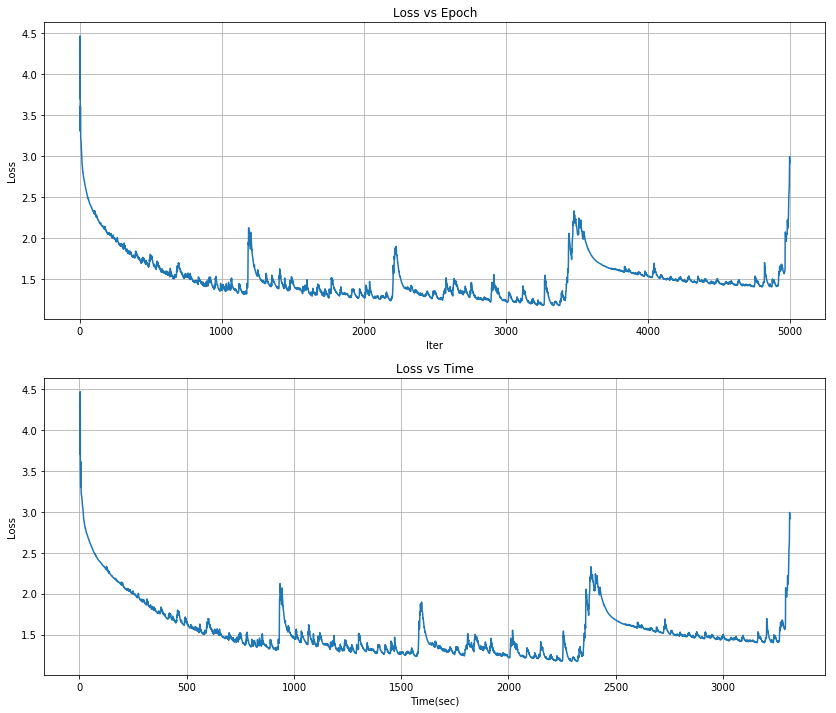

In [7]:
code_gen.Plot_Loss()

### Best 모델과의 비교를 위한 모델 로드
- 저장된 Loss 최저점 당시의 모델을 불러와 예측모델을 생성해봅시다.

In [8]:
saver = tf.train.Saver()
saver.restore(sess, './Models/rnn_text_BEST.ckpt')
code_gen.Make_Text(sess)

INFO:tensorflow:Restoring parameters from ./Models/rnn_text_BEST.ckpt
et__ts=n. mpinmmaa_''TF_CPP_MIN_LOG_LEVEL']='2'
import 
ogging

mport timgiimp rt timgin
s sfl
mport tf.ri_ .t  =s tfl
leg fng.getLogge.('tens=rsll'').setLeo
l(lbggingsWARNING)

class CharRNN(object):
   efus_inxt_b(self, sumtraining  satch_size  
f.fmnrollings  va.ab_size, s                et rn kize_ voxugrad_norm, inlsdding_size  va.slayers,                 etrt)ng rate) valeen vo.se_ .t.0, inpui_doceo_t'0.0, userbatch=True
:
    self.iatch_size,= satch_sizer     elf.indeunrollings = tf.tcnroqlings     selisa s eriatch=
      self.iatch_size,= s
       elf.indeunrollings = t
    self.indet__size = tf.ti_ size     self.indab_snzex* 
n.ab_sizex     elf.inx_grad_norm)= [ftagrad_norm,
   self.indeunyers-= nf.tleyers,    self.indedding_size = 
n.edding_size     self.indet_= tf.ti_    self.indet__s= [f.ti_ .    self.indet_drze _t'= [f.ti_lroeo_t'    selisaedding_size == 0:
       elf.indet_drze = 
n.ab_sizex       elf.i